In [1]:
# !git clone https://github.com/NSCC-COGS/GDAA2030.git

Cloning into 'GDAA2030'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 323 (delta 48), reused 19 (delta 7), pack-reused 214
Receiving objects: 100% (323/323), 17.39 MiB | 7.92 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [2]:
%cd /content/GDAA2030/tutorial2/jordankempff

/content/GDAA2030/tutorial2/jordankempff


In [0]:
%%capture
%run GDAA2030_T2_JordanKempff_getLandsat.ipynb

In [4]:
print(selectedScene)

productId                   LC08_L1TP_018030_20190326_20190326_01_RT
entityId                                       LC80180302019085LGN00
acquisitionDate                           2019-03-26 16:03:21.712109
cloudCover                                                      0.28
processingLevel                                                 L1TP
path                                                              18
row                                                               30
min_lat                                                      42.1013
min_lon                                                     -81.5586
max_lat                                                      44.2429
max_lon                                                     -78.7385
download_url       https://s3-us-west-2.amazonaws.com/landsat-pds...
lat                                                          43.1721
lon                                                         -80.1485
dist                              

In [0]:
from matplotlib import pyplot as plt
import tifffile
import numpy as np
import warnings
warnings.filterwarnings('ignore')
def ourPlot(a, interpolation = 'bilinear', histogram=True):
  stats = {
      'max' : np.nanmax(a),
      'min' : np.nanmin(a),
      'mean' : np.nanmean(a),
      'std' : np.nanstd(a),
      'bitDepth' : a.dtype,
      'dimensions' : a.shape,
      'tope_left_value' : a[0,0]
  }

  for item in stats:
    print('%s: %s'%(item, stats[item]))

  plt.cla()
  plt.subplot(121)
  plt.imshow(a ,interpolation = interpolation)
  if histogram:
    plt.subplot(122)
    plt.hist(a.flatten(),bins=100)
    s0 = stats['mean'] - stats['std']
    s1 = stats['mean'] + stats['std']
    plt.axvline(s0,c='red')
    plt.axvline(s1,c='red')

def stdScale(a, n=1, inplace=False):
  if inplace:
    b=a
  else:
    b=a.copy()
  s0 = np.nanmean(b) - np.nanstd(b)/n
  s1 = np.nanmean(b) + np.nanstd(b)/n 
  print('Scale from %f to %f' %(s0,s1))
  b[b<s0] = s1
  b[b>s1] = s1
  return b

def convert32(a, maskVal=0, inplace=False):
  if inplace:
    b=a
  else:
    b=a.copy()
  mask = b == maskVal
  b = b.astype(np.float32)
  b[mask] = np.nan
  return b

def normalize(a, inplace=False):
  if inplace:
    b=a
  else:
    b=a.copy()
  
  if b.dtype != np.float32:
    b = b.astype(np.float32)
  
  b -= np.nanmin(b)
  b /= np.nanmax(b)
  return b

def scale8bit(a, return_mask=True, inplace=False):
  if inplace:
    b=a
  else:
    b=a.copy()

  if return_mask:
    mask = ~np.isnan(b)
  b *= 255
  b = b.astype(np.uint8)

  if return_mask:
    mask = mask.astype(np.uint8)
    mask *= 255

    return b,mask

  else:
    return b
  

def makeComposite(bands=[4,3,2]):
  images = []
  for band in bands:
    imageUrl, imagePath = glf.getImageIO(selectedScene, band, imageDir)
    glf.downloadImage(imageUrl,imagePath)
    im = tifffile.imread(imagePath)[::10,::10] 
    images.append(im)
    
  return np.dstack(images)



def makeCompositeRGBA(bands=[4,3,2]):
  images = []
  for band in bands:
    imageUrl, imagePath = glf.getImageIO(selectedScene, band, imageDir)
    glf.downloadImage(imageUrl,imagePath)
    im = tifffile.imread(imagePath)[::10,::10]
    im = convert32(im, inplace=True)
    im = stdScale(im, n=.5, inplace=True) 
    im = normalize(im, inplace=True)
    im,mask = scale8bit(im, return_mask=True, inplace=True)
    images.append(im)
  images.append(mask)

  return np.dstack(images)

max: 65535
min: 0
mean: 7285.886673469645
std: 5484.758296956665
bitDepth: uint16
dimensions: (7851, 7721)
tope_left_value: 0


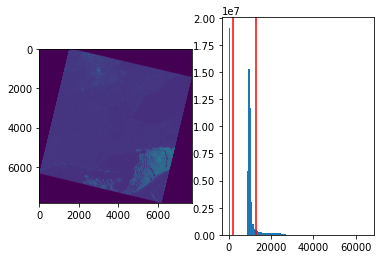

In [13]:
imageFullSize = tifffile.imread(imagePath)
ourPlot(imageFullSize)

max: 28678
min: 0
mean: 7267.742128582668
std: 5488.474120388247
bitDepth: uint16
dimensions: (786, 773)
tope_left_value: 0


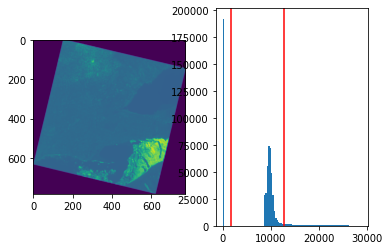

In [14]:
image = imageFullSize[::10,::10]

ourPlot(image)

max: True
min: False
mean: 0.31640546563568794
std: 0.46507316300938234
bitDepth: bool
dimensions: (786, 773)
tope_left_value: True


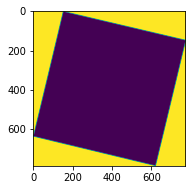

In [15]:
mask = image == 0
ourPlot(mask, histogram=False)

max: 1
min: 0
mean: 0.31640546563568794
std: 0.46507316300938234
bitDepth: int32
dimensions: (786, 773)
tope_left_value: 1


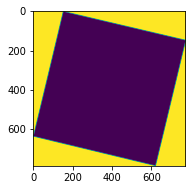

In [19]:
from scipy.ndimage import label
labelMask,unused = label(mask)
ourPlot(labelMask, histogram=False)

In [20]:
print(image.mean())
print(image[~mask].mean())

7267.742128582668
10631.65628634097


max: True
min: False
mean: 0.12461609867375054
std: 0.3302831007258539
bitDepth: bool
dimensions: (786, 773)
tope_left_value: False


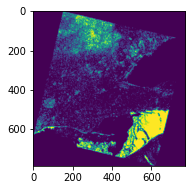

In [21]:
thresholdImage = image > image[~mask].mean()
ourPlot(thresholdImage, histogram=False)

max: True
min: False
mean: 0.12461609867375054
std: 0.3302831007258539
bitDepth: bool
dimensions: (786, 773)
tope_left_value: False


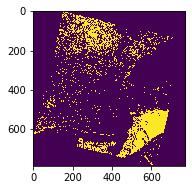

In [22]:
ourPlot(thresholdImage, interpolation = 'nearest', histogram=False)

max: 14059
min: 0
mean: 973.962013107782
std: 3108.9509898542215
bitDepth: int32
dimensions: (786, 773)
tope_left_value: 0


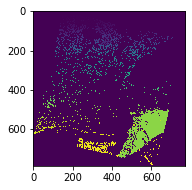

In [24]:
labelThreshold,unused = label(thresholdImage)
ourPlot(labelThreshold, interpolation = 'nearest', histogram=False)

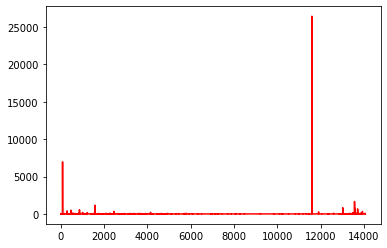

In [25]:
labels, pixelCount = np.unique(labelThreshold[labelThreshold!=0], return_counts=True)
plt.plot(labels, pixelCount, c='red')

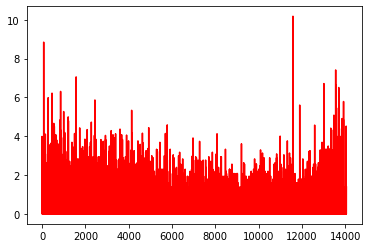

In [26]:
plt.plot(labels, np.log(pixelCount), c='red')

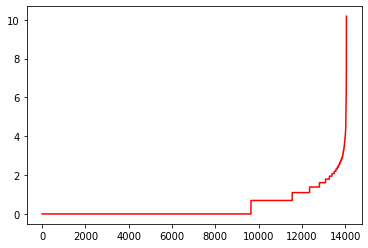

In [27]:
pixelCountorted = np.sort(pixelCount)
plt.plot(np.log(pixelCountorted), c='red')

Label: 11590
max: True
min: False
mean: 0.04348742054518103
std: 0.20395162367460473
bitDepth: bool
dimensions: (786, 773)
tope_left_value: False


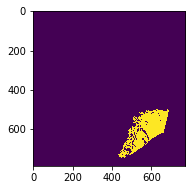

In [28]:
sorter = np.argsort(pixelCount)
largestLabel = labels[sorter][-1]
print('Label:',largestLabel)

largestArea = (labelThreshold == largestLabel)
ourPlot((largestArea), interpolation='nearest', histogram=False)

Label: 77
max: True
min: False
mean: 0.01144708992096488
std: 0.10637694324103411
bitDepth: bool
dimensions: (786, 773)
tope_left_value: False


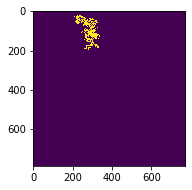

In [30]:
secondLargestLabel = labels[sorter][-2]
print('Label:', secondLargestLabel)
secondLargestArea = (labelThreshold == secondLargestLabel)
ourPlot((secondLargestArea), interpolation='nearest', histogram=False)

max: True
min: False
mean: 0.00627738331539325
std: 0.0789808696717432
bitDepth: bool
dimensions: (786, 773)
tope_left_value: False


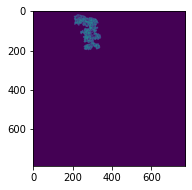

In [31]:
from skimage.morphology import dilation
secondLargestPerm = ~secondLargestArea & dilation(secondLargestArea)
ourPlot(secondLargestPerm, interpolation='bilinear', histogram=False)

max: 28678.0
min: 8635.0
mean: 10631.655
std: 2881.3408
bitDepth: float32
dimensions: (786, 773)
tope_left_value: nan


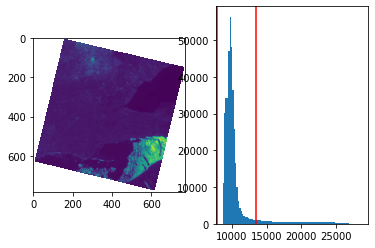

In [32]:
image32 = image.astype(np.float32)
image32[mask] = np.nan
ourPlot(image32)

max: 28678.0
min: 10632.0
mean: 19367.703
std: 4323.615
bitDepth: float32
dimensions: (786, 773)
tope_left_value: nan


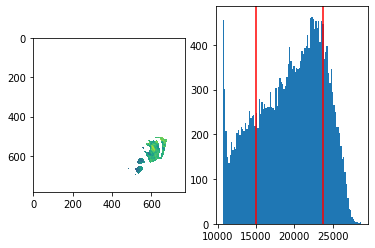

In [34]:
image32LargestArea = image32.copy()
image32LargestArea[~largestArea] = np.nan
ourPlot(image32LargestArea)

Scale from 7750.314453 to 13512.996094
max: 13512.996
min: 8635.0
mean: 10162.051
std: 1247.1135
bitDepth: float32
dimensions: (786, 773)
tope_left_value: nan


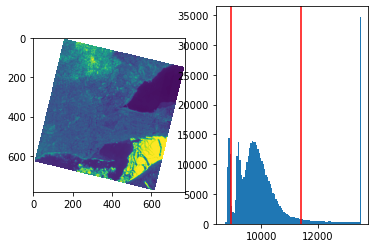

In [37]:
image32_scaled = stdScale(image32)
ourPlot(image32_scaled)

Scale from 15044.087891 to 23691.318359
max: 23691.318
min: 15045.0
mean: 21306.988
std: 2689.9458
bitDepth: float32
dimensions: (786, 773)
tope_left_value: nan


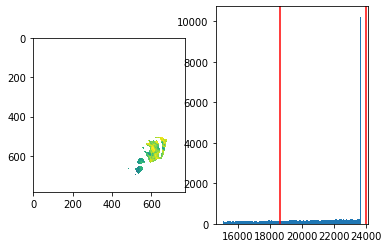

In [38]:
image32LargestArea_scaled = stdScale(image32LargestArea)
ourPlot(image32LargestArea_scaled)

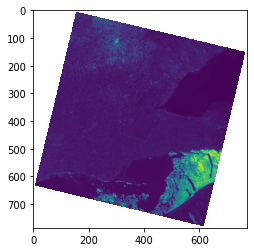

In [42]:
from skimage.feature import peak_local_max

localMaxPts = peak_local_max(image32, min_distance=20)
plt.imshow(image32)
plt.scatter(localMaxPts[:, 1], localMaxPts[:, 0], c='red')

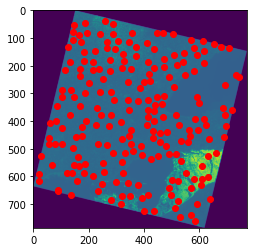

In [43]:
localMaxPts = peak_local_max(image, min_distance=20)
plt.imshow(image)
plt.scatter(localMaxPts[:, 1], localMaxPts[:, 0], c='red')

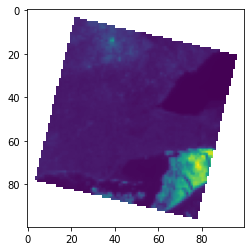

In [44]:
import skimage
image32Resamp = skimage.transform.resize(image32, output_shape = [100,100])
plt.imshow(image32Resamp)

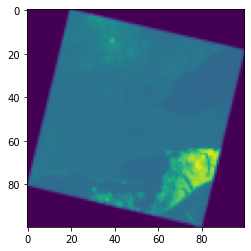

In [45]:
imageResamp = skimage.transform.resize(image, output_shape = [100,100])
plt.imshow(imageResamp)

max: 1.0
min: 0.0
mean: 0.3130485
std: 0.25566104
bitDepth: float32
dimensions: (786, 773)
tope_left_value: nan


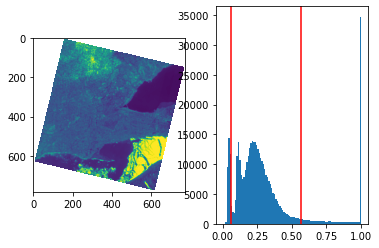

In [47]:
image32_scaled_norm = normalize(image32_scaled)
ourPlot(image32_scaled_norm)

max: 255
min: 0
mean: 54.25605601256135
std: 65.40592894645914
bitDepth: uint8
dimensions: (786, 773)
tope_left_value: 0


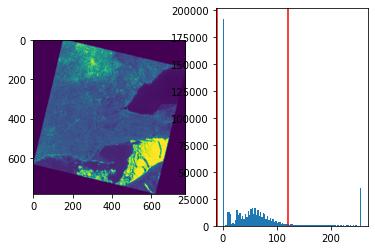

In [49]:
image8Bit,mask8Bit = scale8bit(image32_scaled_norm)
ourPlot(image8Bit)

max: 255
min: 0
mean: 174.31660626289957
std: 118.59365656739244
bitDepth: uint8
dimensions: (786, 773)
tope_left_value: 0


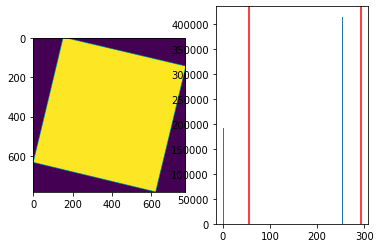

In [51]:
ourPlot(mask8Bit)

https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/018/030/LC08_L1TP_018030_20190326_20190326_01_RT/LC08_L1TP_018030_20190326_20190326_01_RT_B4.TIF
.\images/LC08_L1TP_018030_20190326_20190326_01_RT_B4.TIF
downloading... https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/018/030/LC08_L1TP_018030_20190326_20190326_01_RT/LC08_L1TP_018030_20190326_20190326_01_RT_B4.TIF
https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/018/030/LC08_L1TP_018030_20190326_20190326_01_RT/LC08_L1TP_018030_20190326_20190326_01_RT_B3.TIF
.\images/LC08_L1TP_018030_20190326_20190326_01_RT_B3.TIF
downloading... https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/018/030/LC08_L1TP_018030_20190326_20190326_01_RT/LC08_L1TP_018030_20190326_20190326_01_RT_B3.TIF
https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/018/030/LC08_L1TP_018030_20190326_20190326_01_RT/LC08_L1TP_018030_20190326_20190326_01_RT_B2.TIF
.\images/LC08_L1TP_018030_20190326_20190326_01_RT_B2.TIF
downloading... https://s3-us-west-2.amazonaws.com

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


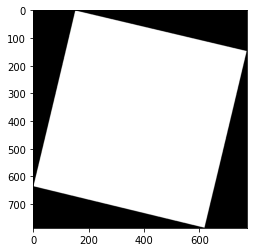

In [53]:
compositeImage = makeComposite([4,3,2])
plt.imshow(compositeImage)

https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/018/030/LC08_L1TP_018030_20190326_20190326_01_RT/LC08_L1TP_018030_20190326_20190326_01_RT_B4.TIF
.\images/LC08_L1TP_018030_20190326_20190326_01_RT_B4.TIF
.\images/LC08_L1TP_018030_20190326_20190326_01_RT_B4.TIF already found
Scale from 2313.334961 to 16301.088867
https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/018/030/LC08_L1TP_018030_20190326_20190326_01_RT/LC08_L1TP_018030_20190326_20190326_01_RT_B3.TIF
.\images/LC08_L1TP_018030_20190326_20190326_01_RT_B3.TIF
.\images/LC08_L1TP_018030_20190326_20190326_01_RT_B3.TIF already found
Scale from 2826.765625 to 15769.806641
https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/018/030/LC08_L1TP_018030_20190326_20190326_01_RT/LC08_L1TP_018030_20190326_20190326_01_RT_B2.TIF
.\images/LC08_L1TP_018030_20190326_20190326_01_RT_B2.TIF
.\images/LC08_L1TP_018030_20190326_20190326_01_RT_B2.TIF already found
Scale from 3796.329590 to 16237.840332
max: 255
min: 0
mean: 80.07013543940037
std: 96.1

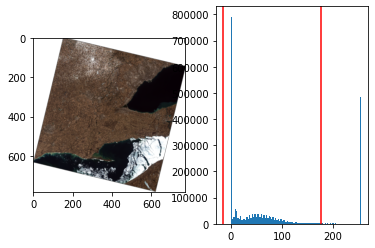

In [56]:
imageRGBA = makeCompositeRGBA([4,3,2])
ourPlot(imageRGBA)

max: 255
min: 0
mean: 174.31702596209868
std: 118.59349088404545
bitDepth: uint8
dimensions: (786, 773)
tope_left_value: 0


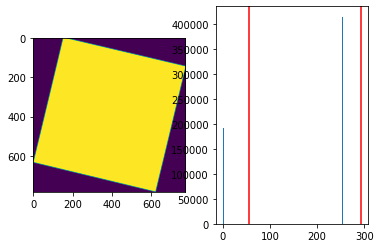

In [57]:
ourPlot(imageRGBA[:,:,3])

In [58]:
import folium

m = folium.Map([selectedScene.lat, selectedScene.lon], zoom_start=7)

folium.raster_layers.ImageOverlay(
    image=imageRGBA,
    bounds=[[selectedScene.min_lat, selectedScene.min_lon], 
            [selectedScene.max_lat, selectedScene.max_lon]],).add_to(m)

m